# Exploratory Data Analysis - MIMIC-IV Dataset in PostgreSQL

The notebook has been implemented using Python 3.10.11.  
The MIMIC-IV v2.2 dataset has been loaded into PostgreSQL server running PostgreSQL 15.2 (Ubuntu 15.2-1.pgdg22.04+1).  
We suggest creating a virtual environment for this notebook.  
You need to install the following packages to run this notebook:

| Package Name | License                                                                                                                 | Documentation                           |
|--------------|-------------------------------------------------------------------------------------------------------------------------|-----------------------------------------|
| psycopg2     | [![License: LGPL v3](https://img.shields.io/badge/License-LGPL_v3-blue.svg)](https://www.gnu.org/licenses/lgpl-3.0)     | [Docs](https://www.psycopg.org/)        |
| pandas       | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://pandas.pydata.org/)      |
| numpy        | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://numpy.org/)              |
| seaborn      | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://seaborn.pydata.org/)     |
| scipy        | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://scipy.org/)              |
| tomli        | [![License: MIT](https://img.shields.io/badge/License-MIT-blue.svg)](https://opensource.org/licenses/MIT)               | [Docs](https://github.com/hukkin/tomli) |
| tqdm         | [![License](https://img.shields.io/pypi/l/tqdm.svg)](https://github.com/tqdm/tqdm/blob/master/LICENCE)                  | [Docs](https://tqdm.github.io/)         |
| matplotlib   | [(BSD-compatible, PSF-based)](https://matplotlib.org/stable/users/project/license.html)                                 | [Docs](https://matplotlib.org/)         |


In [ ]:
"""Update pip and install requirements."""
%pip install --upgrade pip
%pip install -r requirements.txt

In [1]:
"""Relevant imports for EDA; setup and styling."""

# data manipulation
import numpy as np
import pandas as pd

# data vizualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec

# tqdm for progress bars
from tqdm import tqdm

# default styling for plots
plt.style.use("ggplot")  # gnuplot style
rcParams["figure.figsize"] = 12, 6  # figure size
from matplotlib.colors import ListedColormap

# hls colormap for sns styled pie charts using matplotlib
hls = ListedColormap(sns.color_palette("hls").as_hex())

In [3]:
"""Functions for database connection, query execution, dataframe plotting."""

import tomli as toml
import psycopg2 as pg
from typing import Any


def read_config(path: str) -> dict:
    """Read config file and return config dict."""
    with open(path, "rb") as f:
        config = toml.load(f)["database"]
    return config


def connect_to_db(config: dict) -> Any:
    """Connect to database and return connection object."""
    conn = pg.connect(**config)
    cur = conn.cursor()
    return conn, cur


def read_sql(path: str) -> str:
    """Read SQL file and returns string"""
    with open(path, "r") as f:
        sql = f.read()
    return sql


def sql_to_df(path: str, params: dict = None) -> pd.DataFrame:
    """Read SQL file, execute query and return pandas DataFrame.
    
    Optionally, pass parameters to query using the params dict.
    """
    if params is None:
        params = {}
    conn, cur = connect_to_db(read_config("./config.toml"))
    cur.execute(read_sql(path), params)
    df = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
    conn.close()
    return df


def plot_corr_matrix(
    df: pd.DataFrame,
    method: str = "pearson",
    title: str="",
    figsize=(10, 5),
    linewidth=0.3,
    fmt=".2f",
    annot_kws={"size": 10},
    cmap="Spectral_r",
    cbar=True,
    ax=None,
    cbar_kws={"shrink": 0.8},
) -> None:
    """Plot heatmap of correlation matrix."""
    # set figure size
    if ax is None:
        plt.subplots(figsize=figsize)
    corr = df.corr(method)
    sns.heatmap(
        corr,
        cbar=cbar,  # show color bar? yes/no
        annot=True,  # show numbers in cells? yes/no
        square=True,  # square cells? yes/no
        linewidths=linewidth,  # linewidth between cells
        fmt=fmt,  # precision
        annot_kws=annot_kws,  # size of numbers in cells
        yticklabels=df.columns,  # y-axis labels
        xticklabels=df.columns,  # x-axis labels
        cmap=cmap,  # color palette
        ax=ax,  # axes object
        cbar_kws=cbar_kws,  # shrink color bar
    )
    if title:
        plt.title(title)
    if ax is None:
        plt.show()


def plot_boxplot_grid(df: pd.DataFrame, target: str) -> None:
    """Plot boxplots of multiple columns against a single target variable."""
    # calculate number of rows and columns
    n_cols = int(np.ceil(np.sqrt(len(df.columns) - 1)))
    n_rows = int(np.ceil((len(df.columns) - 1) / n_cols))
    # create figure and axes
    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_cols, figsize=(n_cols * 6, n_rows * 5)
    )
    # iterate over columns, rows and create boxplots
    for col, ax in zip(df.columns.drop(target), axes.flatten()):
        sns.boxplot(x=target, y=col, data=df, ax=ax)
        # set title to column name vs. target
        ax.set_title(f"{col} vs. {target}")
    plt.show()


def plot_corr_matrix_diff(
    df_one: pd.DataFrame,
    df_two: pd.DataFrame,
    method: str = "pearson",
    figsize=(10, 5),
    cmap="vlag",
    title="",
    ax=None,
) -> None:
    """Plot heatmap of difference of correlation matrices."""
    # calculate difference of correlation matrices
    corr_diff = df_one.corr(method) - df_two.corr(method)
    # plot heatmap
    plt.subplots(figsize=figsize)
    # draw arrows in cells according to correlation difference?
    sns.heatmap(
        corr_diff,
        annot=True,
        annot_kws={"size": 10},
        cbar=True,
        cmap=cmap,
        fmt=".2f",
        square=True,
        center=0,
        ax=ax,
    )
    plt.title(title)
    if ax is None:
        plt.show()


def plot_pie_chart(df, col="race", title="", ax=None, cmap=hls, explode=.1):
    """Plot pie chart for a given column in a dataframe."""
    explode = [explode] * len(df[col].value_counts())
    df[col].value_counts().plot.pie(
        shadow=True,
        autopct="%1.1f%%",
        startangle=90,
        title=title,
        cmap=cmap,
        ax=ax,
        labeldistance=1.1,
        pctdistance=0.5,
        explode=explode,
    )
    if ax is None:
        plt.show()

### Patient Age Distribution - General Hospital Population

In [ ]:
gen_pop_age = sql_to_df("./sql/demographics_age_patients.sql")

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
fig.suptitle("Age Distribution of Hospital Patients", fontsize=16)
# create color palette
palette = dict(zip(["F", "M"], sns.color_palette()))
# plot histograms
a1 = sns.histplot(
    data=gen_pop_age,
    x="age",
    hue="gender",
    kde=True,
    multiple="layer",
    ax=axes[0],
    palette=palette,
)
a2 = sns.histplot(
    data=gen_pop_age,
    x="age",
    hue="gender",
    multiple="fill",
    ax=axes[1],
    palette=palette,
    stat="percent",
)
# set title, x- and y-labels for subplots
a1.set(xlabel="Age", ylabel="Count", title="Age Distribution")
a2.set(xlabel="Age", ylabel="Percent", title="Gender Distribution")
# add labels to bars
# for container in a1.containers:
# a1.bar_label(container)

### Patient Age Distribution - ICU Population

In [ ]:
icu_pop_age = sql_to_df("./sql/demographics_age_icu.sql")

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 6), sharex=True)
# set title
fig.suptitle("Age Distribution of Patients in ICU", fontsize=16)
# create color palette
palette = dict(zip(["F", "M"], sns.color_palette()))
# plot histograms
a1 = sns.histplot(
    data=icu_pop_age.copy(),
    x="age",
    hue="gender",
    kde=True,
    multiple="layer",
    ax=axes[0],
    palette=palette,
)
a2 = sns.histplot(
    data=icu_pop_age.copy(),
    x="age",
    hue="gender",
    multiple="fill",
    ax=axes[1],
    palette=palette,
    stat="percent",
)
# set title, x- and y-labels for subplots
a1.set(xlabel="Age", ylabel="Count", title="Age Distribution")
a2.set(xlabel="Age", ylabel="Percent", title="Gender Distribution")

### Age Distribution of Patients with Sepsis-3

In [ ]:
sepsis_pop_age = sql_to_df("./sql/demographics_age_sepsis.sql")

In [ ]:
# create color palette
palette = dict(zip(["F", "M"], sns.color_palette()))
# plot histograms
g = sns.displot(
    sepsis_pop_age,
    x="age",
    col="sepsis",
    hue="gender",
    facet_kws=dict(margin_titles=True),
    binwidth=2,
    height=6,
    kde=True,
    palette=palette,
)
# set title
g.set_titles(col_template="Sepsis={col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Age Distribution of Patients with and without Sepsis", fontsize=16)

### General Demographics

In [ ]:
demographics = sql_to_df("./sql/demographics_general.sql")

In [ ]:
# TODO: correlate categorical demographics with sepsis target
# this includes: ethnicity, marital status, language, (pre-conditions?), (age groups?)

### Ethnicity of Hospital Patients

In [5]:
asian_map = {
    "ASIAN": "Asian",
    "ASIAN - ASIAN INDIAN": "Asian",
    "ASIAN - CHINESE": "Asian",
    "ASIAN - KOREAN": "Asian",
    "ASIAN - SOUTH EAST ASIAN": "Asian",
}
black_map = {
    "BLACK": "Black",
    "BLACK/AFRICAN AMERICAN": "Black",
    "BLACK/AFRICAN": "Black",
    "BLACK/CAPE VERDEAN": "Black",
    "BLACK/CARIBBEAN ISLAND": "Black",
    "BLACK/HAITIAN": "Black",
}
white_map = {
    "WHITE": "White",
    "WHITE - BRAZILIAN": "White",
    "WHITE - EASTERN EUROPEAN": "White",
    "WHITE - OTHER EUROPEAN": "White",
    "WHITE - RUSSIAN": "White",
}
hispanic_map = {
    "HISPANIC": "Hispanic",
    "HISPANIC/LATINO - CENTRAL AMERICAN": "Hispanic",
    "HISPANIC/LATINO - COLOMBIAN": "Hispanic",
    "HISPANIC/LATINO - CUBAN": "Hispanic",
    "HISPANIC/LATINO - DOMINICAN": "Hispanic",
    "HISPANIC/LATINO - GUATEMALAN": "Hispanic",
    "HISPANIC/LATINO - HONDURAN": "Hispanic",
    "HISPANIC/LATINO - MEXICAN": "Hispanic",
    "HISPANIC/LATINO - PUERTO RICAN": "Hispanic",
    "HISPANIC/LATINO - SALVADORAN": "Hispanic",
    "HISPANIC OR LATINO": "Hispanic",
    "SOUTH AMERICAN": "Hispanic",
}
other_map = {
    "OTHER": "Other",
    "PORGTUGUESE": "Other",
    "MULTIPLE RAACE/ETHNICITY": "Other",
    "AMERICAN INDIAN/ALASKA NATIVE": "Other",
}
unknown_map = {
    "UNABLE TO OBTAIN": "Unknown",
    "UNKNOWN": "Unknown",
    "PATIENT DECLINED TO ANSWER": "Unknown",
}
all_map = asian_map | black_map | white_map | hispanic_map | other_map | unknown_map

In [ ]:
# run query
df = sql_to_df("./sql/race.sql")
# apply general ethnicity mapping
df["mapped_race"] = df["race"].map(all_map)

In [ ]:
ax = sns.histplot(data=df, x="mapped_race", hue="gender", multiple="dodge")
# add bar labels
for container in ax.containers:
    ax.bar_label(container, rotation=90)
# rotate x-tick labels
plt.xticks(rotation=90)

In [ ]:
from matplotlib.gridspec import GridSpec

asian = df[df["race"].isin(asian_map)]
black = df[df["race"].isin(black_map)]
white = df[df["race"].isin(white_map)]
hispanic = df[df["race"].isin(hispanic_map)]
other = df[df["race"].isin(other_map)]
unknown = df[df["race"].isin(unknown_map)]

fig = plt.figure(figsize=(20, 20))
gs = GridSpec(3, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[2, 2])

plot_pie_chart(df, "mapped_race", title="All Patients", ax=ax1)
plot_pie_chart(asian, title="Asian", ax=ax2, explode=0.05)
plot_pie_chart(black, title="Black", ax=ax3, explode=0.05)
plot_pie_chart(white, title="White", ax=ax4, explode=0.05)
plot_pie_chart(hispanic, title="Hispanic", ax=ax5, explode=0.05)
plot_pie_chart(other, title="Other", ax=ax6, explode=0.05)
plot_pie_chart(unknown, title="Unknown", ax=ax7, explode=0.05)

In [ ]:
# create color palette
palette = dict(zip(["F", "M"], sns.color_palette()))
# plot histograms
g = sns.displot(
    df,
    x="race",
    col="sepsis",
    hue="gender",
    facet_kws=dict(margin_titles=True),
    binwidth=2,
    height=6,
    kde=True,
    palette=palette,
)
g.set_titles(col_template="Sepsis={col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Ethnicity", fontsize=16)
# rotate x-tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#### Demographics in ICU

In [ ]:

# run icu query
dfICU = sql_to_df("./sql/race_ICU.sql")
dfICU["mapped_race"] = df["race"].map(all_map)

In [ ]:

ax = sns.histplot(data=dfICU, x="mapped_race", hue="gender", multiple="dodge")
#add bar labels
for container in ax.containers:
    ax.bar_label(container, rotation=90)
# rotate x-tick labels
plt.xticks(rotation=90)

In [ ]:
from matplotlib.gridspec import GridSpec

asian = dfICU[dfICU["race"].isin(asian_map)]
black = dfICU[dfICU["race"].isin(black_map)]
white = dfICU[dfICU["race"].isin(white_map)]
hispanic = dfICU[dfICU["race"].isin(hispanic_map)]
other = dfICU[dfICU["race"].isin(other_map)]
unknown = dfICU[dfICU["race"].isin(unknown_map)]

fig = plt.figure(figsize=(20, 20))
gs = GridSpec(3, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[2, 2])

plot_pie_chart(dfICU, "mapped_race", title="ICU Patients", ax=ax1)
plot_pie_chart(asian, title="Asian", ax=ax2, explode=0.05)
plot_pie_chart(black, title="Black", ax=ax3, explode=0.05)
plot_pie_chart(white, title="White", ax=ax4, explode=0.05)
plot_pie_chart(hispanic, title="Hispanic", ax=ax5, explode=0.05)
plot_pie_chart(other, title="Other", ax=ax6, explode=0.05)
plot_pie_chart(unknown, title="Unknown", ax=ax7, explode=0.05)

In [ ]:
# create color palette
palette = dict(zip(["F", "M"], sns.color_palette()))
# plot histograms
g = sns.displot(
    dfICU,
    x="race",
    col="sepsis",
    hue="gender",
    facet_kws=dict(margin_titles=True),
    binwidth=2,
    height=6,
    kde=True,
    palette=palette,
)
g.set_titles(col_template="Sepsis={col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Ethnicity on ICU", fontsize=16)
# rotate x-tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Time to Infection - How long does it take for a patient to get infected after admission to the ICU?

In [ ]:
tti = sql_to_df("./sql/time_to_infection.sql")

In [ ]:
graph = sns.boxplot(x=tti["time_to_infection"])
# set x-axis scale to log (symmetric log scale to include negative values)
graph.set_xscale("symlog")
graph.tick_params(axis="x", which="minor", length=1)
# add vertical lines for ICU admission and ICU stay length at 8, 24 and 72 hours
graph.axvline(0, color="orange", linestyle="--")
graph.axvline(8, color="green", linestyle="--")
graph.axvline(24, color="green", linestyle="--")
graph.axvline(72, color="green", linestyle="--")
graph.text(
    0.05, 0.48, "ICU Admission", va="bottom", ha="left", color="orange", rotation=90
)
graph.text(
    8.5, 0.48, "8 hour ICU stay", va="bottom", ha="left", color="green", rotation=90
)
graph.text(
    25.5, 0.48, "24 hour ICU stay", va="bottom", ha="left", color="green", rotation=90
)
graph.text(
    74.5, 0.48, "72 hour ICU stay", va="bottom", ha="left", color="green", rotation=90
)
# add text box with summary statistics
graph.text(
    -35,
    0.45,
    tti["time_to_infection"].describe().round(3).to_string(),
    va="bottom",
    color="black",
    bbox=dict(facecolor="white", alpha=0.5),
)
plt.title("Sepsis Onset Time for ICU Patients")
plt.xlabel("Time to Infection (hours, log scale)")
plt.show()

In [ ]:
sns.histplot(data=tti, x="time_to_infection", stat="percent", cumulative=True, kde=True)
sns.rugplot(data=tti, x="time_to_infection", height=-0.02, clip_on=False, lw=1, alpha=0.5)
# set title 
plt.xlabel("Time to Infection (hours)")

#### Notes on Sepsis Onset Time

The MIMIC-IV authors note the following in their sepsis3 concept:
> As many variables used in SOFA are only collected in the ICU, this query can only define sepsis-3 onset within the ICU.
 
This somewhat explains the distribution of sepsis-3 onset times in the figure above. The distribution of sepsis-3 onset times is heavily skewed towards the point of admission to the ICU. Patients that may already have sepsis upon admission to the ICU will only be identified as having sepsis using the sepsis-3 criteria once the SOFA relevant variables have been collected. This is usually within the first few hours of admission to the ICU. It appears that the majority of patients that develop sepsis in the ICU do so within the first 24 hours of admission. Some patients have a recorded onset time that is well before their admission to the ICU. This is likely due to the fact that for some patients SOFA score variables may have been collected in the ED or the ward. This is the case for 39 patients in total. 31408 patients experience their sepsis onset in the first 24 hours of their icu stay. The mean onset time is 6.9h.

### Blood Gas Analysis - First 24 Hours in the ICU



In [ ]:
bg_first_24h = sql_to_df("./sql/first_day_bg.sql")

In [ ]:
# filter for columns with max/min values
bg_first_24h_min_max = bg_first_24h.filter(regex="(_max|_min|sepsis)$")
# plot correlation matrix
plot_corr_matrix(
    bg_first_24h_min_max,
    title="Blood Gas Analysis Correlation Matrix - Max/Min [24h ICU]",
    figsize=(25, 20),
    linewidth=0,
    cbar=True,
    cbar_kws={"shrink": 0.8},
)
# filter for columns with mean/std values
bg_first_24h_mean_std = bg_first_24h.filter(regex="(_mean|_std|sepsis)$")
# plot correlation matrix
plot_corr_matrix(
    bg_first_24h_mean_std,
    title="Blood Gas Analysis Correlation Matrix - Mean/Std [24h ICU]",
    figsize=(25, 20),
    linewidth=0,
    cbar=True,
    cbar_kws={"shrink": 0.8},
)

### Pre Septic Blood Gas Analysis - 8 Hours before Sepsis Onset

For patients without sepsis, the measurement interval is from ICU admission time to ICU admission time +8 hours.
This may or may not be a valid approach.

In [ ]:
# get blood gas analysis data for different time windows before sepsis onset
bg_pre_septic_2h = sql_to_df("./sql/pre_septic_bg.sql", {"window_size_h": 2})
bg_pre_septic_4h = sql_to_df("./sql/pre_septic_bg.sql", {"window_size_h": 4})
bg_pre_septic_6h = sql_to_df("./sql/pre_septic_bg.sql", {"window_size_h": 6})
bg_pre_septic_8h = sql_to_df("./sql/pre_septic_bg.sql", {"window_size_h": 8})

In [ ]:
# filter for columns with max/min values
bg_pre_septic_8h_min_max = bg_pre_septic_8h.filter(regex="(_max|_min|sepsis)$")
# plot correlation matrix
plot_corr_matrix(
    bg_pre_septic_8h_min_max,
    title="Blood Gas Analysis Correlation Matrix - Min/Max [8h Pre-Septic]",
    figsize=(25, 20),
    linewidth=0,
    cbar=True,
)
# filter for columns with mean/std values
bg_pre_septic_8h_mean_std = bg_pre_septic_8h.filter(regex="(_mean|_std|sepsis)$")
# plot correlation matrix
plot_corr_matrix(
    bg_pre_septic_8h_mean_std,
    title="Blood Gas Analysis Correlation Matrix - Mean/Std [8h Pre-Septic]",
    figsize=(25, 20),
    linewidth=0,
    cbar=True,
)

In [ ]:
# calculate correlation matrices
bg_corr_2h = bg_pre_septic_2h.corr().iloc[-1:]
bg_corr_4h = bg_pre_septic_4h.corr().iloc[-1:]
bg_corr_6h = bg_pre_septic_6h.corr().iloc[-1:]
bg_corr_8h = bg_pre_septic_8h.corr().iloc[-1:]

# add a column to record the time before sepsis onset
bg_corr_2h["h_before_onset"] = -2
bg_corr_4h["h_before_onset"] = -4
bg_corr_6h["h_before_onset"] = -6
bg_corr_8h["h_before_onset"] = -8

concat = pd.concat([bg_corr_2h, bg_corr_4h, bg_corr_6h, bg_corr_8h])
melted = concat.melt(id_vars=["sepsis", "h_before_onset"], value_vars=concat.columns[:-2])

grid = sns.relplot(
    data=melted,
    y="value",
    x="h_before_onset",
    col="variable",
    hue="sepsis",
    kind="line",
    col_wrap=11,
    height=2.5,
    facet_kws=dict(margin_titles=True),
    marker="o",
)
grid.set_titles(col_template="{col_name}")
grid.fig.tight_layout()
grid.fig.suptitle("Correlation between Blood Gas Components and Sepsis Onset Time", y=1.02, fontsize=16)

# draw horizontal line at y=0
for ax in grid.axes.flatten():
    ax.axhline(0, color="green", linestyle="--")

### Vital Signs - 24 hours after ICU admission

Technically its -6 to +24 hours after ICU admission. The first 6 hours are recorded because the first 6 hours are used to calculate the SOFA score.

In [ ]:
vs_first_24h = sql_to_df("./sql/first_day_vitalsign.sql")

In [ ]:
# filter for columns with max/min values
vs_first_24h_min_max = vs_first_24h.filter(regex="(_max|_min|sepsis|height|age)$")
# plot correlation matrix
plot_corr_matrix(
    vs_first_24h_min_max,
    title="Vital Signs Correlation Matrix - Min/Max [24h ICU]",
    figsize=(15, 10),
    linewidth=0,
)
# filter for columns with mean/std values
vs_first_24h_mean_std = vs_first_24h.filter(regex="(_mean|_std|sepsis|height|age)$")
# plot correlation matrix
plot_corr_matrix(
    vs_first_24h_mean_std,
    title="Vital Signs Correlation Matrix - Mean/Std [24h ICU]",
    figsize=(15, 10),
    linewidth=0,
)

### Vital Signs - 2/4/6/8 hours before Sepsis Onset

In [ ]:
vs_pre_septic_2h = sql_to_df("./sql/pre_septic_vitalsign.sql", {"window_size_h": 2})
vs_pre_septic_4h = sql_to_df("./sql/pre_septic_vitalsign.sql", {"window_size_h": 4})
vs_pre_septic_6h = sql_to_df("./sql/pre_septic_vitalsign.sql", {"window_size_h": 6})
vs_pre_septic_8h = sql_to_df("./sql/pre_septic_vitalsign.sql", {"window_size_h": 8})

In [ ]:
vs_pre_septic_8h_min_max = vs_pre_septic_8h.filter(regex="(_max|_min|sepsis|height|age)$")
# plot correlation matrices side by side
plot_corr_matrix(
    vs_pre_septic_8h_min_max,
    title="Vital Signs Correlation Matrix - Max/Min [8h Pre-Septic]",
    figsize=(15, 10),
    linewidth=0,
)
# filter for columns with mean/std values
vs_pre_septic_8h_mean_std = vs_pre_septic_8h.filter(regex="(_mean|_std|sepsis|height|age)$")
# plot correlation matrix
plot_corr_matrix(
    vs_pre_septic_8h_mean_std,
    title="Vital Signs Correlation Matrix - Mean/Std [8h Pre-Septic]",
    figsize=(15, 10),
    linewidth=0,
)

In [ ]:
plot_corr_matrix_diff(
    vs_first_24h_min_max,
    vs_pre_septic_8h_min_max,
    figsize=(15, 10),
    title="Vital Sign Correlation Difference - Min/Max [24h ICU - 8h Pre-Septic]",
)
plot_corr_matrix_diff(
    vs_first_24h_mean_std,
    vs_pre_septic_8h_mean_std,
    figsize=(15, 10),
    title="Vital Sign Correlation Difference - Mean/Std [24h ICU - 8h Pre-Septic]",
)

In [ ]:
# create a dataframe that records the correlation between each vital sign and sepsis
# use only the last row of the correlation matrix
vs_corr_2h = vs_pre_septic_2h.corr().iloc[-1:]
vs_corr_4h = vs_pre_septic_4h.corr().iloc[-1:]
vs_corr_6h = vs_pre_septic_6h.corr().iloc[-1:]
vs_corr_8h = vs_pre_septic_8h.corr().iloc[-1:]

# add a column to record the time before sepsis onset
vs_corr_2h["h_before_onset"] = -2
vs_corr_4h["h_before_onset"] = -4
vs_corr_6h["h_before_onset"] = -6
vs_corr_8h["h_before_onset"] = -8

# combine the dataframes into one, row-wise
concat = pd.concat([vs_corr_2h, vs_corr_4h, vs_corr_6h, vs_corr_8h])
melted = concat.melt(
    id_vars=["sepsis", "h_before_onset"], value_vars=concat.columns[:-2]
)

# plot as facetgrid
grid = sns.relplot(
    data=melted,
    y="value",
    x="h_before_onset",
    col="variable",
    hue="sepsis",
    kind="line",
    col_wrap=10,
    height=2.5,
    marker="o",
)
grid.set_titles(col_template="{col_name}")
grid.fig.suptitle(
    "Correlation between Blood Gas Components and Sepsis Onset Time",
    y=1.02,
    fontsize=16,
)
grid.fig.tight_layout()

# draw horizontal line at y=0
for ax in grid.axes.flatten():
    ax.axhline(0, color="green", linestyle="--")

### Lab Results

In [ ]:
lr_first_24h = sql_to_df("./sql/first_day_lab.sql")

In [ ]:
# filter for columns with max/min values
lr_first_24h_min_max = lr_first_24h.filter(regex="(_max|_min|sepsis)$")
# plot correlation matrix
plot_corr_matrix(
    lr_first_24h_min_max,
    title="Lab Results Correlation Matrix - Min/Max [24h ICU]",
    figsize=(35, 30),
    linewidth=0,
)
# filter for columns with mean/std values
lr_first_24h_mean_std = lr_first_24h.filter(regex="(_mean|_std|sepsis)$")
# plot correlation matrix
plot_corr_matrix(
    lr_first_24h_mean_std,
    title="Lab Results Correlation Matrix - Mean/Std [24h ICU]",
    figsize=(35, 30),
    linewidth=0,
)

In [ ]:
lr_pre_septic_2h = sql_to_df("./sql/pre_septic_lab.sql", {"window_size_h": 2})
lr_pre_septic_4h = sql_to_df("./sql/pre_septic_lab.sql", {"window_size_h": 4})
lr_pre_septic_6h = sql_to_df("./sql/pre_septic_lab.sql", {"window_size_h": 6})
lr_pre_septic_8h = sql_to_df("./sql/pre_septic_lab.sql", {"window_size_h": 8})

In [ ]:
lr_pre_septic_8h_min_max = lr_pre_septic_8h.filter(regex="(_max|_min|sepsis)$")

plot_corr_matrix(
    lr_pre_septic_8h_min_max,
    title="Lab Results Correlation Matrix - Min/Max [8h Pre-Septic]",
    figsize=(35, 30),
    linewidth=0,
)

lr_pre_septic_8h_mean_std = lr_pre_septic_8h.filter(regex="(_mean|_std|sepsis)$")

plot_corr_matrix(
    lr_pre_septic_8h_mean_std,
    title="Lab Results Correlation Matrix - Mean/Std [8h Pre-Septic]",
    figsize=(35, 30),
    linewidth=0,
)

In [ ]:
plot_corr_matrix_diff(
    lr_first_24h_min_max,
    lr_pre_septic_8h_min_max,
    figsize=(35, 30),
    title="Lab Results Correlation Difference - Min/Max [24h ICU - 8h Pre-Septic]",
)
plot_corr_matrix_diff(
    lr_first_24h_mean_std,
    lr_pre_septic_8h_mean_std,
    figsize=(35, 30),
    title="Lab Results Correlation Difference - Mean/Std [24h ICU - 8h Pre-Septic]",
)

lr_pre_septic_6h_min_max = lr_pre_septic_6h.filter(regex="(_max|_min|sepsis)$")
plot_corr_matrix_diff(
    lr_pre_septic_8h_min_max,
    lr_pre_septic_6h_min_max,
    figsize=(35, 30),
    title="Lab Results Correlation Difference - Min/Max [8h Pre-Septic - 6h Pre-Septic]",
)

In [ ]:
# create a dataframe that records the correlation between each vital sign and sepsis
# use only the last row of the correlation matrix
lr_corr_2h = lr_pre_septic_2h.corr().iloc[-1:]
lr_corr_4h = lr_pre_septic_4h.corr().iloc[-1:]
lr_corr_6h = lr_pre_septic_6h.corr().iloc[-1:]
lr_corr_8h = lr_pre_septic_8h.corr().iloc[-1:]

# add a column to record the time before sepsis onset
lr_corr_2h["h_before_onset"] = -2
lr_corr_4h["h_before_onset"] = -4
lr_corr_6h["h_before_onset"] = -6
lr_corr_8h["h_before_onset"] = -8

# combine the dataframes into one, row-wise
concat = pd.concat([lr_corr_2h, lr_corr_4h, lr_corr_6h, lr_corr_8h])
melted = concat.melt(
    id_vars=["sepsis", "h_before_onset"], value_vars=concat.columns[:-2]
)

# plot as facetgrid
grid = sns.relplot(
    data=melted,
    x="h_before_onset",
    y="value",
    col="variable",
    kind="line",
    col_wrap=10,
    height=2.5,
    marker="o",
)
grid.set_titles(col_template="{col_name}")
grid.fig.suptitle(
    "Correlation between Blood Gas Components and Sepsis Onset Time",
    y=1.02,
    fontsize=16,
)
grid.fig.tight_layout()

# draw horizontal line at y=0
for ax in grid.axes.flatten():
    ax.axhline(0, color="green", linestyle="--")

### Dialysis and Urine Output

In [ ]:
df_dia = sql_to_df("./sql/dialysis_urine_corr.sql")

In [ ]:
plot_corr_matrix(
    df_dia,
    "Dialysis and Urine Output - Correlation Matrix",
    figsize=(10, 5),
    linewidth=0,
)

### Glasgow Coma Scale (GCS)

The Glasgow Coma Scale (GCS) is a neurological scale which aims to give a reliable and objective way of recording the conscious state of a person for initial as well as subsequent assessment. A patient is assessed against the criteria of the scale, and the resulting points give a patient score between 3 (indicating deep unconsciousness) and either 14 (original scale) or 15 (more widely used modified or revised scale). The coma scale has three parameters: eye response (4), verbal response (5) and motor response (6) which are summed up to give the final score. The three values separately as well as their sum are considered in the evaluation of the patient's condition.

The MIMIC-IV concept table `first_day_gcs` contains the first day GCS score for patients in the ICU. Patients that are sedated are assigned a GCS score of 15. The authors of the concept recommend to use the last recorded GCS score before sedation for sedated patients (compare to SAPS II score). SAPS II is a severity score for ICU patients that is calculated based on the worst values for 12 physiological variables during the first 24 hours after admission. The GCS score is one of the 12 variables. Patients that receive ventilation through a tracheal tube are marked in the `gcs_unable` column.

In [ ]:
df = sql_to_df("./sql/pre_septic_gcs.sql")

In [ ]:
plot_corr_matrix(df, title="Correlation Matrix - Pre Septic Glasgow Coma Scale", figsize=(20, 10), linewidth=0)

#### Notes on the GCS Heatmap
The only positive correlation is between the `gcs_unable` column and the sepsis target variable. This is somewhat expected, as patients that are marked as unable are patients that receive ventilation through a tracheal tube. Ventilation is probably an indicator for the severity of the patients condition, as it is (probably) only necessary for more severe conditions. The other correlations will be negative, as the GCS score is a severity score. The lower the score, the more severe the condition. The gcs verbal subscore has the highest correlation between the GCS subscores and the sepsis target variable. 

Note that the query is skewed by design, since sedated patients receive a GCS of 15. This should be seen as a limitation of this specific query. The heatmap is still useful to get a general idea of the correlations between the GCS subscores and the sepsis target variable.

In [ ]:
# show distribution of gcs values
sns.displot(df, x="gcs_total", kind="kde", hue="sepsis", fill=True)

#### Notes on the Distribution of the GCS Score
The distribution of the GCS score is skewed to the right. The majority of patients have a GCS score of 15, which is the maximum score. We can observe, that sepsis patients have a higher density of lower GCS scores than non-sepsis patients. The distribution itself follow a similar pattern between sepsis/non-sepsis patients. This leads to the assumption, that the distribution of the GCS score may not be a good indicator for sepsis.

### Ventilation

In [ ]:
df_ventilation = sql_to_df("./sql/ventilation_corr.sql")

In [ ]:
plot_corr_matrix(df_ventilation, title="Correlation Matrix - Ventilation", method="pearson")

#### Notes on the Ventilation Heatmap
The GCS Heatmap contains a positive correlation between the `gcs_unable` column and the sepsis target variable. This heatmap shows a similar relation between the `non_invasive_vent` column aswell as the `invasive_vent` column and the sepsis target variable. This further corroborates the theory, that the `gcs_unable` column is actually just a correlation factor between ventilation and sepsis and has nothing to do with the actual GCS score.

We should note the following limitations for the query used to generate this heatmap:
- The query includes the whole ICU stay of the patient. This means that the patient may have been ventilated at some point during their ICU stay, but not necessarily during the first 24 hours.
- As the query contains the whole ICU stay, the patient may have been non-invasively ventilated at some point and then invasively ventilated at a later point. 
- The sepsis onset time is not considered in the query. This means that the query does not consider the ventilation status of the patient at the time of sepsis onset. This may be a useful insight to have, as it may be an indicator for sepsis onset.

### Patient Age Distribution

In [ ]:
all_ages = sql_to_df("./sql/all_ages.sql")

In [ ]:
plt.plot(all_ages[0], all_ages[1])
plt.title('Age of all patients')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [ ]:
icu_ages = sql_to_df("./sql/all_icu_ages.sql")

In [ ]:
plt.plot(icu_ages[0], icu_ages[1])
plt.title('Age of all ICU patients')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### Using the latest query, test for variable correlations with sepsis

In [3]:
WINDOW_SIZE_H = 8
WINDOW_STOP_SIZE_H = 2
RANDOM_STATE = 42

# Extract the training data from the database
# This query returns a table with all the features for each patient in the cohort
# variables = sql_to_df("./sql/variables_filtered.sql", {"window_size_h": WINDOW_SIZE_H, "window_stop_size_h": WINDOW_STOP_SIZE_H})
df = sql_to_df("./sql/variables_slope.sql", {"window_size_h": WINDOW_SIZE_H, "window_stop_size_h": WINDOW_STOP_SIZE_H})

# Filter out duplicate columns (by name)
df = df.loc[:, ~df.columns.duplicated()]

# Summary statistics, increase number of shown columns
pd.set_option("display.max_columns", 500)
df.describe()

,subject_id,stay_id,heart_rate_slope,sbp_slope,dbp_slope,mbp_slope,resp_rate_slope,temperature_slope,sepsis
count,4.407100e+04,4.407100e+04,36139.000000,35860.000000,35860.000000,35843.000000,35921.000000,18037.000000,44071.000000
mean,1.500386e+07,3.498777e+07,-0.003546,-0.005716,-0.004109,-0.005308,0.000146,0.000228,0.119126
std,2.891951e+06,2.891922e+06,0.084168,0.124798,0.101024,0.112388,0.042696,0.003306,0.323940
min,1.000003e+07,3.000015e+07,-9.922680,-7.666667,-7.666667,-9.000000,-6.000000,-0.094500,0.000000
25%,1.249176e+07,3.247738e+07,-0.024286,-0.040335,-0.028591,-0.030580,-0.009524,-0.000917,0.000000
50%,1.500981e+07,3.499232e+07,-0.001548,-0.002381,-0.002381,-0.002406,0.000000,0.000000,0.000000
75%,1.752491e+07,3.748817e+07,0.019524,0.034286,0.022857,0.024155,0.009622,0.001169,0.000000
max,1.999999e+07,3.999981e+07,3.500000,6.666667,4.000000,4.666667,1.750000,0.070747,1.000000


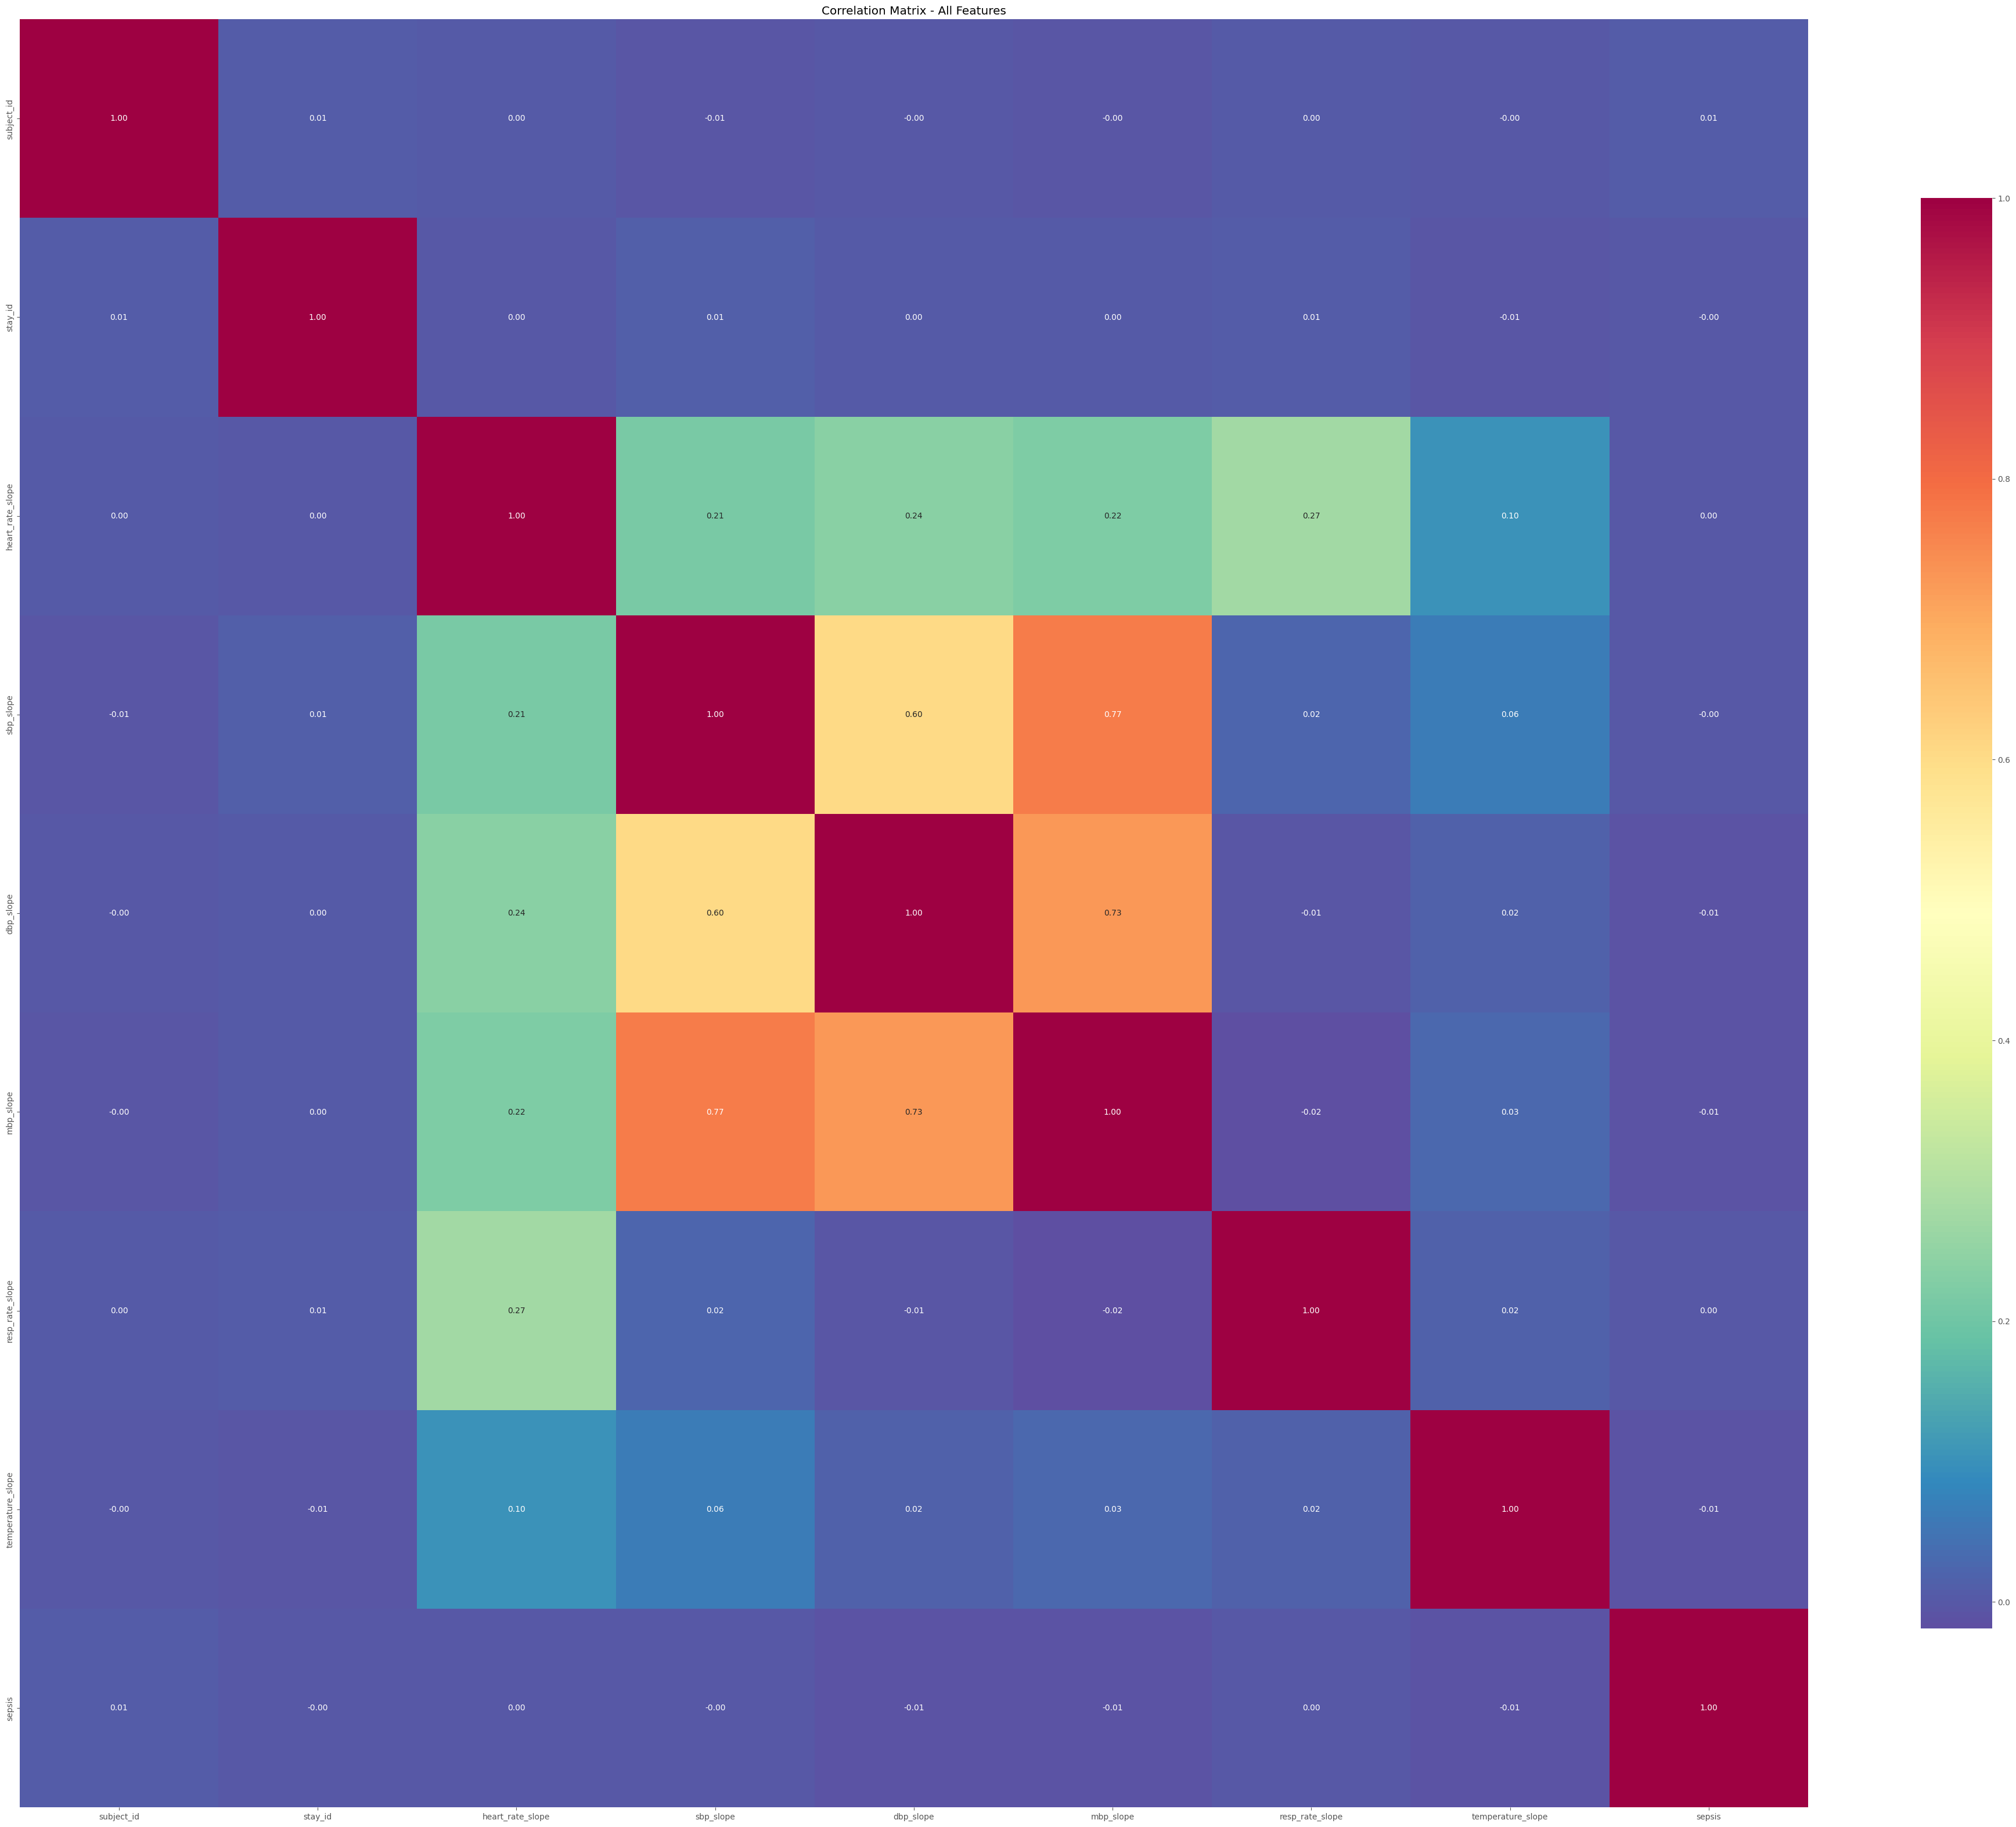

Number of features with correlation > 0.1: 0
Number of features with correlation < 0.1: 8


In [4]:
# Ensure that sepsis is the last column
sepsis_col = df.pop("sepsis")
df["sepsis"] = sepsis_col

# variables.fillna(-1, inplace=True)

plot_corr_matrix(df, title="Correlation Matrix - All Features", figsize=(50, 40), linewidth=0)

# List all features with a correlation > cuttoff with the target variable "sepsis"
cutoff = 0.1

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Get correlations of 'target_variable' 
correlations_target = correlation_matrix["sepsis"]

# Get features that have a correlation higher than 0.15 with 'target_variable'
features_high_corr = correlations_target[correlations_target.abs() >= cutoff]
features_low_corr = correlations_target[correlations_target.abs() < cutoff]

# Exclude the target variable itself
features_high_corr = features_high_corr.drop("sepsis")

# Print number of features
print(f"Number of features with correlation > {cutoff}: " + str(len(features_high_corr)))

# Print number of features that fall below the cutoff
print(f"Number of features with correlation < {cutoff}: " + str(len(features_low_corr)))

### Demographics of the cohort

In [6]:
df = sql_to_df("./sql/demographics_cohort.sql")

# Convert decimals to floats
df["age"] = df["age"].astype(float)
# Map all ethnicities to 6 categories
df["mapped_race"] = df["race"].map(all_map)

In [7]:
# Split by sepsis3 value
df_sepsis_1 = df[df["sepsis"] == 1]
df_sepsis_0 = df[df["sepsis"] == 0]

# Count number of patients with sepsis
print(f"Number of patients with sepsis: {len(df_sepsis_1)}")
print(f"Number of patients without sepsis: {len(df_sepsis_0)}")

# Calculate mean age
sepsis_0_mean_age = df_sepsis_0["age"].mean()
sepsis_1_mean_age = df_sepsis_1["age"].mean()
# Calculate standard deviation of age
sepsis_0_std_age = df_sepsis_0["age"].std()
sepsis_1_std_age = df_sepsis_1["age"].std()

print(f"Sepsis = 0 age: {sepsis_0_mean_age} +/- {sepsis_0_std_age}")
print(f"Sepsis = 1 age: {sepsis_1_mean_age} +/- {sepsis_1_std_age}")

# Count how many female/male patients there are ("gender" either M or F)
sepsis_0_num_female = df_sepsis_0[df_sepsis_0["gender"] == 'F'].shape[0]
sepsis_0_num_male = df_sepsis_0[df_sepsis_0["gender"] == 'M'].shape[0]
sepsis_1_num_female = df_sepsis_1[df_sepsis_1["gender"] == 'F'].shape[0]
sepsis_1_num_male = df_sepsis_1[df_sepsis_1["gender"] == 'M'].shape[0]

print(f"Sepsis = 0; {sepsis_0_num_male} male & {sepsis_0_num_female} female")
print(f"Sepsis = 0; {sepsis_0_num_male / len(df_sepsis_0) * 100:.3f}% male & {sepsis_0_num_female / len(df_sepsis_0) * 100:.3f}% female")
print(f"Sepsis = 1; {sepsis_1_num_male} male & {sepsis_1_num_female} female")
print(f"Sepsis = 1; {sepsis_1_num_male / len(df_sepsis_1) * 100:.3f}% male & {sepsis_1_num_female / len(df_sepsis_1) * 100:.3f}% female")

# Calculate mean time to onset
sepsis_1_mean_time_to_onset = df_sepsis_1["time_to_onset"].mean().total_seconds()
sepsis_1_median_time_to_onset = df_sepsis_1["time_to_onset"].median().total_seconds()
sepsis_1_median_time_to_onset /= 3600
sepsis_1_mean_time_to_onset /= 3600

sepsis_0_mean_time_to_onset = df_sepsis_0["time_to_onset"].mean().total_seconds()
sepsis_0_median_time_to_onset = df_sepsis_0["time_to_onset"].median().total_seconds()
sepsis_0_median_time_to_onset /= 3600
sepsis_0_mean_time_to_onset /= 3600

print(f"Mean time to onset, sepsis 1 (median): {sepsis_1_mean_time_to_onset:.2f}h ({sepsis_1_median_time_to_onset:.2f}h)")
print(f"Mean time to onset, sepsis 0 (median): {sepsis_0_mean_time_to_onset:.2f}h ({sepsis_0_median_time_to_onset:.2f}h)")

# Calculate ethnicity distribution
# Absolute counts, not normalized
print(df_sepsis_0["mapped_race"].value_counts())
print(df_sepsis_1["mapped_race"].value_counts())
# Percentages, normalized to 100%
print((df_sepsis_0["mapped_race"].value_counts(normalize=True) * 100))
print((df_sepsis_1["mapped_race"].value_counts(normalize=True) * 100))

Number of patients with sepsis: 5250
Number of patients without sepsis: 38821
Sepsis = 0 age: 63.858896556098394 +/- 17.43926831776848
Sepsis = 1 age: 64.8159700321761 +/- 16.925587687825395
Sepsis = 0; 21015 male & 17806 female
Sepsis = 0; 54.133% male & 45.867% female
Sepsis = 1; 2900 male & 2350 female
Sepsis = 1; 55.238% male & 44.762% female
Mean time to onset, sepsis 1 (median): 31.26h (15.35h)
Mean time to onset, sepsis 0 (median): 15.90h (12.27h)
mapped_race
White       26328
Black        4432
Unknown      3789
Hispanic     1504
Other        1346
Asian        1153
Name: count, dtype: int64
mapped_race
White       3470
Unknown      614
Black        570
Other        198
Hispanic     189
Asian        156
Name: count, dtype: int64
mapped_race
White       68.292177
Black       11.496161
Unknown      9.828284
Hispanic     3.901224
Other        3.491388
Asian        2.990766
Name: proportion, dtype: float64
mapped_race
White       66.769290
Unknown     11.814508
Black       10.967866


In [44]:
df = sql_to_df("./sql/variables_filtered.sql", {"window_size_h": WINDOW_SIZE_H, "window_stop_size_h": WINDOW_STOP_SIZE_H})

# Filter out duplicate columns (by name)
df = df.loc[:, ~df.columns.duplicated()]

# Drop columns that are not useful for training
if "stay_id" in df.columns and "subject_id" in df.columns:
    df.drop(["stay_id", "subject_id"], axis=1, inplace=True)

# Summary statistics
df.describe()

,heart_rate_min,heart_rate_max,heart_rate_mean,heart_rate_std,sbp_min,sbp_max,sbp_mean,sbp_std,dbp_min,dbp_max,dbp_mean,dbp_std,mbp_min,mbp_max,mbp_mean,mbp_std,resp_rate_min,resp_rate_max,resp_rate_mean,resp_rate_std,sepsis,platelets_min,platelets_max,platelets_avg,platelets_std,albumin_min,albumin_max,albumin_mean,albumin_std,bicarbonate_min,bicarbonate_max,bicarbonate_avg,bicarbonate_std,bun_min,bun_max,bun_avg,bun_std,calcium_min,calcium_max,calcium_avg,calcium_std,sodium_min,sodium_max,sodium_avg,sodium_std,potassium_min,potassium_max,potassium_avg,potassium_std,gcs_motor_max,gcs_motor_min,gcs_motor_avg,gcs_motor_stddev,gcs_verbal_max,gcs_verbal_min,gcs_verbal_avg,gcs_verbal_stddev,gcs_eyes_max,gcs_eyes_min,gcs_eyes_avg,gcs_eyes_stddev,gcs_total_max,gcs_total_min,gcs_total_avg,gcs_total_stddev,so2_min,so2_max,so2_mean,so2_std,aado2_calc_min,aado2_calc_max,aado2_calc_mean,aado2_calc_std,hematocrit_min,hematocrit_max,hematocrit_mean,hematocrit_std,hemoglobin_min,hemoglobin_max,hemoglobin_mean,hemoglobin_std,chloride_min,chloride_max,chloride_mean,chloride_std,lactate_min,lactate_max,lactate_mean,lactatee_std,totalco2_min,totalco2_max,totalco2_mean,totalco2_std,ph_min,ph_max,ph_mean,ph_std
count,43663.000000,43663.000000,43663.000000,43526.000000,43581.000000,43581.000000,43581.000000,43295.000000,43579.000000,43579.000000,43579.000000,43291.000000,43553.000000,43553.000000,43553.000000,43268.000000,43497.000000,43497.000000,43497.000000,43264.000000,44071.000000,19049.000000,19049.000000,19049.000000,2061.000000,2800.000000,2800.000000,2800.000000,51.000000,19742.000000,19742.000000,19742.000000,1067.000000,19806.000000,19806.000000,19806.000000,1073.000000,17144.000000,17144.000000,17144.000000,895.000000,19752.000000,19752.000000,19752.00000,1341.000000,20244.000000,20244.000000,20244.000000,1384.000000,40141.000000,40141.000000,40141.000000,23154.000000,40175.000000,40175.000000,40175.000000,23210.000000,40198.000000,40198.000000,40198.000000,23206.000000,40055.000000,40055.000000,40055.000000,23088.000000,2608.000000,2608.000000,2608.000000,914.000000,5700.000000,5700.000000,5700.000000,2400.000000,1972.000000,1972.000000,1972.000000,1204.000000,1972.000000,1972.000000,1972.000000,1204.000000,1885.000000,1885.000000,1885.000000,541.000000,6267.000000,6267.000000,6267.000000,1949.000000,9172.000000,9172.000000,9172.000000,3852.000000,9172.000000,9172.000000,9172.000000,3852.000000
mean,75.761949,91.876440,83.191269,6.013542,106.531993,135.684886,120.831852,10.817924,55.438594,77.388329,65.318585,8.159732,69.815925,92.581460,80.303951,8.411102,14.735844,23.369520,18.697088,3.177606,0.119126,209.881359,212.482598,211.172602,16.174156,3.306357,3.311071,3.308702,0.181552,23.678705,23.795411,23.737151,1.481239,22.946329,23.080430,23.013614,1.680241,8.438842,8.467067,8.452991,0.369185,138.139682,138.308374,138.22445,1.702637,4.135643,4.177280,4.156383,0.419050,5.684437,5.518447,5.606301,0.179227,4.004804,3.826335,3.913582,0.191304,3.637669,3.461789,3.552277,0.182769,13.329097,12.807914,13.073916,0.553168,93.118788,94.329755,93.772938,2.103881,176.715846,235.270135,204.992181,83.527119,28.037525,31.399087,29.497760,2.750377,9.328296,10.452383,9.816027,0.917135,105.764987,106.753316,106.261521,2.026485,2.152915,2.491267,2.322448,0.616878,24.807676,25.960205,25.385115,1.461287,7.356351,7.387545,7.372205,0.038094
std,16.209909,19.100827,16.734794,4.245367,18.902763,22.046538,18.577033,5.941956,12.871091,17.504803,12.807344,5.347370,13.708795,18.425154,12.975039,5.719898,3.937039,5.808272,4.077453,1.811383,0.323940,106.314928,105.794448,105.898651,18.410112,0.646188,0.644746,0.644973,0.201610,4.507322,4.414087,4.446466,1.520321,19.497171,19.616666,19.542686,3.864552,0.778146,0.784834,0.770323,0.651985,5.140040,5.077490,5.08431,1.936776,0.621005,0.659359,0.627429,0.542837,1.054255,1.309613,1.120611,0.636799,1.868146,1.982847,1.887687,0.674898,0.816674,0.965365,0.856239,0.404641,3.331466,3.864956,3.509368,1.346254,10.780390,9.631739,

In [45]:
# Calculate percentage of NaN values in each row
df['percentage_nan'] = df.isnull().mean(axis=1)

# Print the average percentage of NaN values per row
print(f"Average percentage of NaN values per row: {df['percentage_nan'].mean() * 100:.2f}%")

# Now filter the DataFrame based on this percentage:
threshold = 0.2  # Set your threshold
df_filtered = df[df['percentage_nan'] <= threshold]

# If you want to drop the 'percentage_nan' column after the filtering
df_filtered = df_filtered.drop(columns=['percentage_nan'])

# Calc percentage of null values per column
null_values_per_column = df_filtered.isnull().mean() * 100
# Order columns by percentage of null values
null_values_per_column = null_values_per_column.sort_values(ascending=False)
# Print the 20 columns with the highest percentage of null values
print(null_values_per_column[:20])

# How many rows are left?
print(f"Number of rows left: {len(df_filtered)}")

Average percentage of NaN values per row: 53.71%
albumin_std            98.028169
abs_neutrophils_std    96.901408
calcium_std            82.535211
albumin_min            80.845070
albumin_max            80.845070
albumin_mean           80.845070
bicarbonate_std        78.028169
bun_std                77.746479
sodium_std             76.619718
potassium_std          76.338028
chloride_std           76.338028
so2_std                68.169014
calcium_min            53.239437
calcium_max            53.239437
calcium_avg            53.239437
hematocrit_std         43.380282
hemoglobin_std         43.380282
abs_neutrophils_avg    35.492958
abs_neutrophils_min    35.492958
abs_neutrophils_max    35.492958
dtype: float64
Number of rows left: 355


<Axes: title={'center': 'Percentage of null values per variable (Sepsis - Not Sepsis)'}>

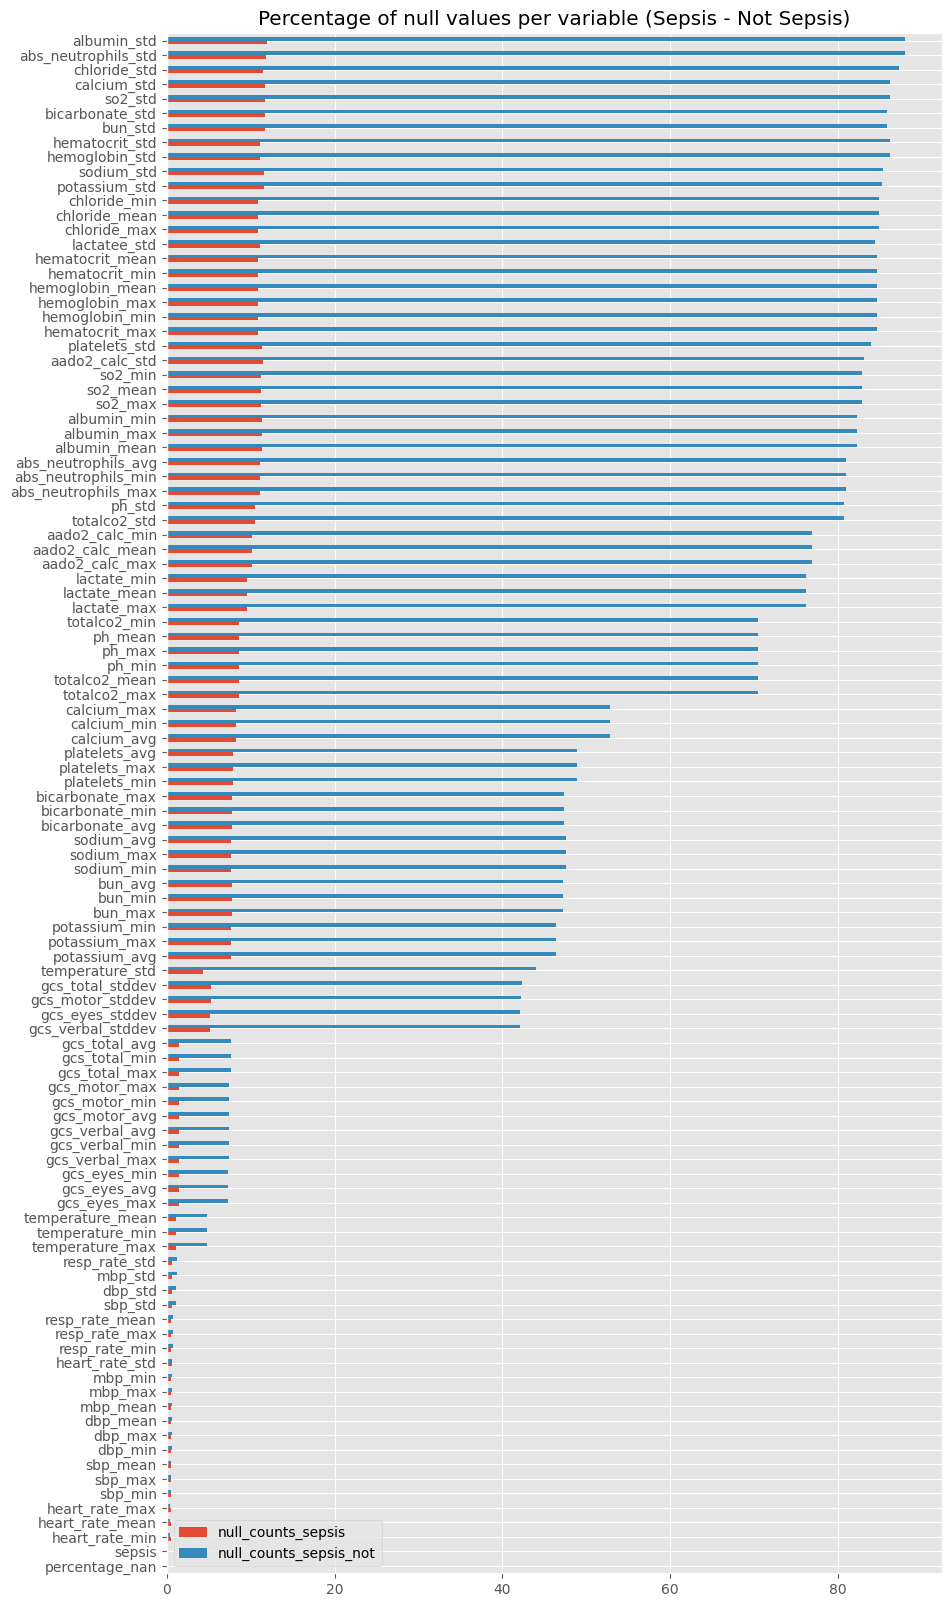

In [46]:
# Count number of null values per column, i.e. per variable
null_counts_sepsis = df[df["sepsis"] == 1].isnull().sum(axis=0).to_frame(name="null_counts")
null_counts_sepsis_not = df[df["sepsis"] == 0].isnull().sum(axis=0).to_frame(name="null_counts")

# Divide by number of rows to get percentage of null values per column, i.e. per variable
# (We use the number of overall rows to obtain the percentage of null values per column, not the number of rows where sepsis == 1 or sepsis == 0)
null_counts_sepsis = (null_counts_sepsis / df.shape[0]) * 100
null_counts_sepsis_not = (null_counts_sepsis_not / df.shape[0]) * 100

# Join null_counts_sepsis and null_counts_sepsis_not to plot them in one plot
null_counts_sepsis = null_counts_sepsis.join(null_counts_sepsis_not, lsuffix="_sepsis", rsuffix="_sepsis_not")

# Calculate the sum of null_counts_sepsis and null_counts_sepsis_not
null_counts_sepsis["sum"] = null_counts_sepsis["null_counts_sepsis"] + null_counts_sepsis["null_counts_sepsis_not"]

# Do not display sum in bar chart, but sort by sum
null_counts_sepsis.sort_values(by="sum", ascending=True).drop("sum", axis=1).plot.barh(figsize=(10, 20), title="Percentage of null values per variable (Sepsis - Not Sepsis)")

### Feature Selection based on the Case-Control Cohort

In [84]:
# Calculate sepsis correlation for all features
WINDOW_SIZE_H = 8
WINDOW_STOP_SIZE_H = 2
variables = sql_to_df("./sql/variables.sql", {"window_size_h": WINDOW_SIZE_H, "window_stop_size_h": WINDOW_STOP_SIZE_H})

# Drop subject_id and stay_id
variables.drop(["stay_id"], axis=1, inplace=True)

# Remove duplicate columns
variables = variables.loc[:, ~variables.columns.duplicated()]

In [91]:
CORRELATION_THRESHOLD = 0.1

def filter_rows_with_nan_values(df, threshold):
    """
    Returns a DataFrame where rows with a percentage of NaN values greater than the threshold are filtered out.
    """
    # Calculate percentage of NaN values in each row
    nan_percentage = df.isnull().mean(axis=1)
    # Keep only those rows that have a NaN percentage less than or equal to the threshold
    filtered_df = df[nan_percentage <= threshold]
    return filtered_df

def get_highly_correlated_features(correlation_series, threshold):
    """
    Returns features that have an absolute correlation value above the specified threshold.
    """
    # Get absolute values
    abs_correlation_series = correlation_series.abs()
    # Filter and sort series
    sorted_highly_correlated_features = correlation_series[abs_correlation_series > threshold].sort_values(ascending=False)
    return sorted_highly_correlated_features

correlation_matrix = variables.corr()
correlations_with_sepsis = correlation_matrix["sepsis"]

highly_correlated_features = get_highly_correlated_features(correlations_with_sepsis, CORRELATION_THRESHOLD)

print(highly_correlated_features)

sepsis                  1.000000
metas_std               0.477263
ld_ldh_std              0.413667
abs_neutrophils_std     0.285801
globulin_min            0.226008
globulin_avg            0.225360
globulin_max            0.224320
atyps_std               0.204782
imm_granulocytes_std    0.133269
temperature_max         0.124200
imm_granulocytes_max    0.106323
platelets_std           0.106278
imm_granulocytes_avg    0.105299
imm_granulocytes_min    0.104105
fibrinogen_std          0.102733
albumin_min            -0.103152
albumin_avg            -0.103619
albumin_max            -0.103940
abs_eosinophils_std    -0.104598
abs_monocytes_std      -0.122326
bands_std              -0.204830
thrombin_avg           -0.286329
thrombin_max           -0.286329
thrombin_min           -0.286329
Name: sepsis, dtype: float64


<Axes: title={'center': 'Percentage of null values per variable (Sepsis - Not Sepsis)'}>

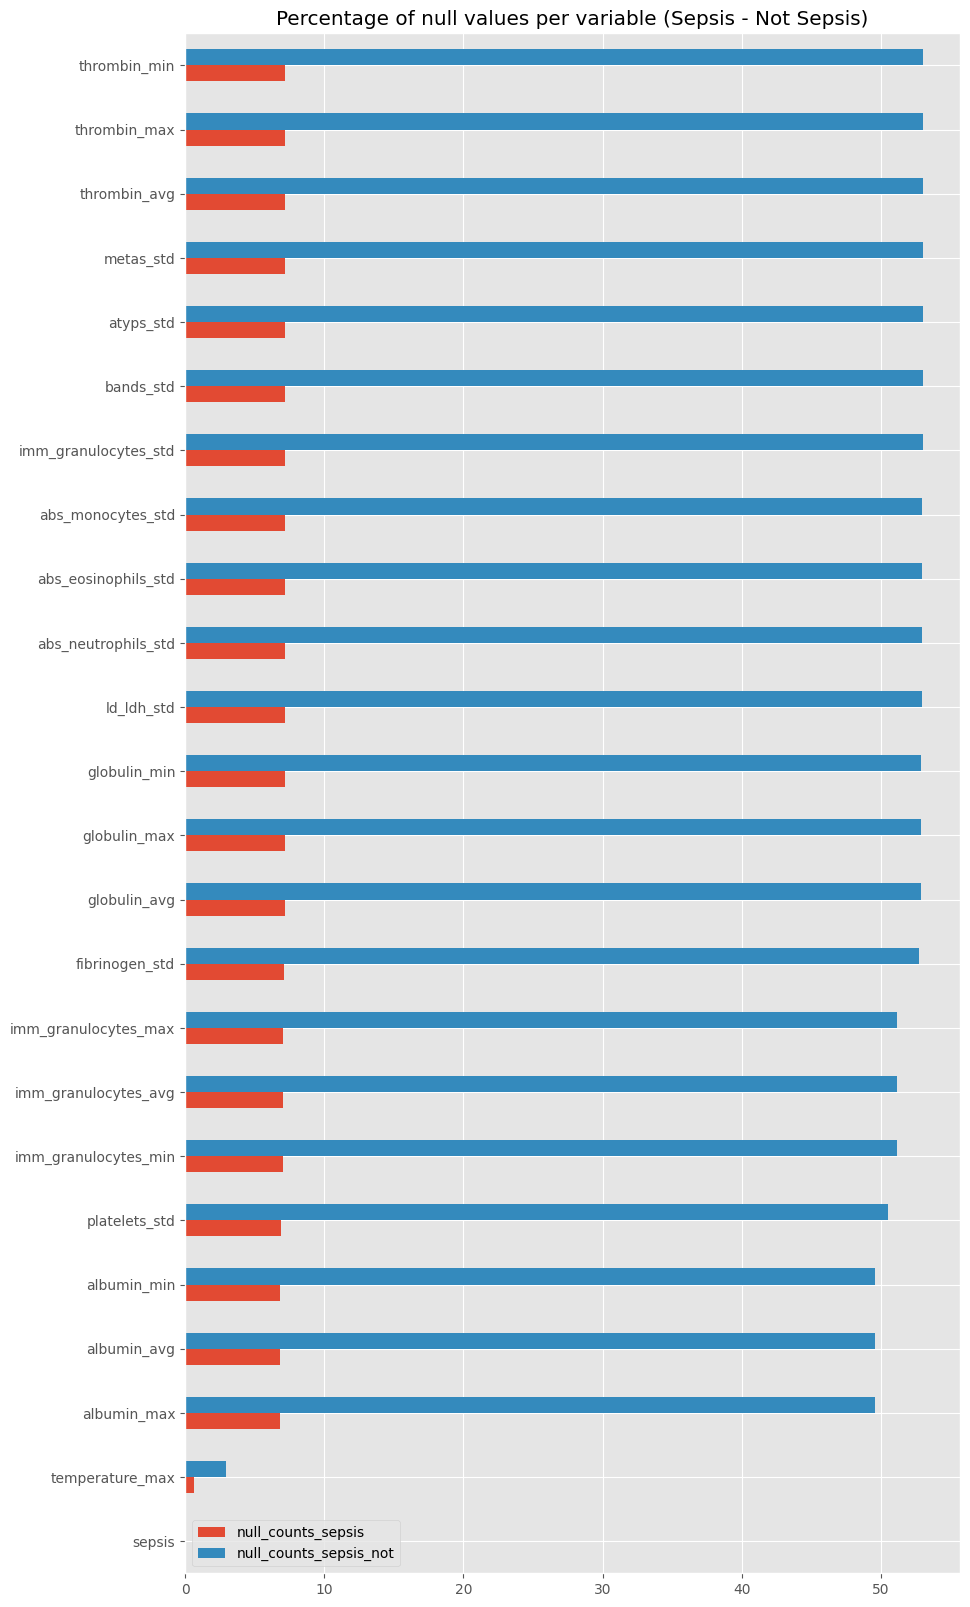

In [93]:
df = variables[highly_correlated_features.index]

# Count number of null values per column, i.e. per variable
null_counts_sepsis = df[df["sepsis"] == 1].isnull().sum(axis=0).to_frame(name="null_counts")
null_counts_sepsis_not = df[df["sepsis"] == 0].isnull().sum(axis=0).to_frame(name="null_counts")

# Divide by number of rows to get percentage of null values per column, i.e. per variable
# (We use the number of overall rows to obtain the percentage of null values per column, not the number of rows where sepsis == 1 or sepsis == 0)
null_counts_sepsis = (null_counts_sepsis / df.shape[0]) * 100
null_counts_sepsis_not = (null_counts_sepsis_not / df.shape[0]) * 100

# Join null_counts_sepsis and null_counts_sepsis_not to plot them in one plot
null_counts_sepsis = null_counts_sepsis.join(null_counts_sepsis_not, lsuffix="_sepsis", rsuffix="_sepsis_not")

# Calculate the sum of null_counts_sepsis and null_counts_sepsis_not
null_counts_sepsis["sum"] = null_counts_sepsis["null_counts_sepsis"] + null_counts_sepsis["null_counts_sepsis_not"]

# Do not display sum in bar chart, but sort by sum
null_counts_sepsis.sort_values(by="sum", ascending=True).drop("sum", axis=1).plot.barh(figsize=(10, 20), title="Percentage of null values per variable (Sepsis - Not Sepsis)")